In [1]:
import pandas as pd

### inference

In [2]:
import torch.cuda
import llama
from util.misc import *
from data.utils import load_and_transform_audio_data

/home/fathinah.izzati/miniconda3/lib/python3.11/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/fathinah.izzati/miniconda3/lib/python3.11/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [3]:
print('loading llama')
model = './ckpts/MU-LLaMA_Finetune2/checkpoint.pth'
llama_dir = '/l/users/fathinah.izzati/ml711/llama'
mert_path = 'm-a-p/MERT-v1-330M'
knn_dir = './ckpts'
llama_type = 'llama-2-7b-chat'
model = llama.load(model_path=model, llama_dir=llama_dir, mert_path=mert_path, knn=True, knn_dir=knn_dir, llama_type=llama_type)

loading llama
Loading LLaMA-Adapter from ./ckpts/MU-LLaMA_Finetune2/checkpoint.pth


Some weights of the model checkpoint at m-a-p/MERT-v1-330M were not used when initializing MERTModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing MERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MERTModel were not initialized from the model checkpoint at m-a-p/MERT-v1-330M and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model args: ModelArgs(dim=4096, n_layers=32, n_heads=32, n_kv_heads=None, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-06, max_batch_size=1, max_seq_len=8192, w_bias=True, w_lora=True, lora_rank=16)


/home/fathinah.izzati/miniconda3/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [4]:
print('Model LLAMA is loaded')
model.eval()
print('Model LLAMA is eval()')

Model LLAMA is loaded
Model LLAMA is eval()


In [5]:
def multimodal_generate(
        audio_path,
        audio_weight,
        prompts,
        cache_size,
        cache_t,
        cache_weight,
        max_gen_len,
        gen_t, top_p
):
    inputs = {}
    audio = load_and_transform_audio_data([audio_path])
    inputs['Audio'] = [audio, audio_weight]
    text_output = None
    with torch.cuda.amp.autocast():
        results = model.generate(inputs, prompts, max_gen_len=max_gen_len, temperature=gen_t, top_p=top_p,
                                     cache_size=cache_size, cache_t=cache_t, cache_weight=cache_weight)
    text_output = results[0].strip()
    return text_output

In [6]:
def encode_prompt(prompt):
    prompts = [llama.format_prompt(prompt)]
    prompts = [model.tokenizer.encode(x, bos=True, eos=False) for x in prompts]
    return prompts

Beat Tracking (GTZAN): This task involves determining the tempo and timing of beats within music. The GTZAN dataset is commonly used for evaluating algorithms that perform this task.

Genre (GTZAN, MTG): Genre classification is the process of categorizing music tracks into genres based on their audio features. Both GTZAN and MTG datasets are used for training and testing models in genre recognition.

Key (GS): Key detection identifies the key of a musical piece. The GS (GiantSteps) dataset, for instance, is a popular choice for evaluating key detection algorithms.

Multi-Label Tagging (MTT, MTG): This involves tagging music tracks with multiple labels that describe various attributes like mood, genre, instruments, etc. MTT (Million Song Dataset tags) and MTG (Music Technology Group tags) datasets are used here.


Instrument Recognition (Nsynth, MTG): This task classifies audio snippets based on the instrument that produces them. Nsynth and MTG datasets offer extensive collections of instrument sounds for testing.

Pitch Detection (Nsynth): Detecting the pitch or fundamental frequency of audio samples, particularly in music. Nsynth, with its large set of labeled notes, is ideal for such tasks.

Emotion Recognition (EMO, MTG): This refers to identifying the emotional content of a music track. EMO and MTG datasets contain tracks labeled with emotional tags that are used to train and evaluate models.

Vocal Technique Detection (VocalSet): This is about identifying specific vocal techniques (like vibrato, yodeling) within a track. VocalSet provides samples with various vocal techniques for analysis.



In [8]:
import os 
import json
folder_path = '/l/users/fathinah.izzati/ml711/data/audio/'
files = []
keys = []
bpms = []
for file in os.listdir(folder_path):
    try:
        
        audio_file = folder_path + file
        pre = audio_file.split('audio/')[0]
        jsonfile = pre+ 'meta/' + file[:-4]+'.json'
        jsonfile = open(jsonfile)
        jsonfile = json.load(jsonfile)
        files.append(file)
        keys.append(jsonfile['key'])
        bpms.append(jsonfile['bpm'])
    except:
        print(file)

4302974 Unknown Artist - Unknown Title*.mp3
3589347 Rihanna - Where Have Been Calvin Harris (Extended Remix)*.mp3
3523229 Kraaska - Blue Planet (Original Mix)*.mp3
4508323 Bob Marley & The Wailers - Could You Be Loved (RAC Remix)*.mp3
3914630 Unknown Artist - Unknown Title*.mp3
4965571 Avicii - Hey Brother (Extended Remix)*.mp3
3772753 Robosonic - The Edge (Original Mix)*.mp3
3572702 (((weight and treble))) - Pure Thing (Original Mix)*.mp3
3478184 Shonky, Dan Ghenacia - Close To The Edge (Original Mix)*.mp3
3479363 Kingthing - Wishful Thinking (Original Mix)*.mp3
3361909 Goldfrapp - Strict Machine (Jamie Jones Remix)*.mp3
4327665 Santos - Zagros Fest (Original Mix)*.mp3
4992190 Lee Coombs - Lilly In The Sky*.mp3
1075123 Unknown Artist - Unknown Title*.mp3
3313070 M83 - Midnight City (Eric Prydz Private Remix)*.mp3
3426022 Flight Facilities - With You Feat. Grovesnor (David August Remix)*.mp3
3572701 (((weight and treble))) - Things to Come (Original Mix)*.mp3
1673811 Vanguard - Loving 

In [9]:
df = pd.DataFrame()
df['file'] = files
df['key'] = keys 
df['bpm'] = bpms

## KEY

In [10]:
q1 = 'What is the key of the piece?'
prompts1 = encode_prompt(q1)

pred_key = []
for j, i in df.iterrows():
    audio_path = folder_path + i['file']
    output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
    pred_key.append(output1)
    
# df['pred_key'] = pred_key
pred_key

2024-05-03 06:45:25.745973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 06:45:25.792755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 06:45:26.939240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['E minor',
 'D minor',
 'A minor',
 'A major',
 'Bb minor',
 'D minor',
 'A minor',
 'F minor',
 'C major',
 'G minor',
 'A major',
 'G minor',
 'B minor',
 'Bb minor',
 'F minor',
 'F minor',
 'F minor',
 'Bb major',
 'A minor',
 'F minor',
 'F minor',
 'A minor',
 'D major',
 'F minor',
 'F minor',
 'F minor',
 'A minor',
 'Gb minor',
 'F minor',
 'D minor',
 'F minor',
 'G minor',
 'G minor',
 'A major',
 'G minor',
 'C major',
 'F minor',
 'F minor',
 'F minor',
 'F minor',
 'A minor',
 'E minor',
 'B minor',
 'F minor',
 'C minor',
 'B minor',
 'A major',
 'G major',
 'Gb minor',
 'F minor',
 'D major',
 'F minor',
 'F minor',
 'G minor',
 'D minor',
 'F minor',
 'A minor',
 'E minor',
 'F minor',
 'F minor',
 'F major',
 'C minor',
 'E major',
 'F minor',
 'Gb minor',
 'E minor',
 'F minor',
 'A major',
 'C minor',
 'F major',
 'F minor',
 'F minor',
 'F minor',
 'A minor',
 'F minor',
 'A major',
 'Eb minor',
 'E minor',
 'G minor',
 'Gb minor',
 'F minor',
 'A minor',
 'F mino

In [11]:
df['pred_key'] = pred_key
df.to_csv('testdata1.csv', index=None)

In [13]:
df

,file,key,bpm,pred_key
0,3363196 Beltek - Party Voice (Original Mix).mp3,E maj,130,E minor
1,"4955428 Juliet Sikora, Tube & Berger - Come On...",A♯ min,122,D minor
2,"1792506 Ruede Hagelstein, Adam Port - Corrosiv...",D min,124,A minor
3,1978917 Bushwacka! - Energy (Original Mix).mp3,B min,123,A major
4,"2673254 Lopazz, Heidi - Funkshovel (SIS Edit).mp3",D min,128,Bb minor
...,...,...,...,...
531,190477 Rob Smith - Give Love (Original Mix).mp3,D maj,138,D minor
532,1970992 Shlomi Aber - New York Dreamer (Alix A...,D♯ min,124,Gb minor
533,3642384 Slok - Lonely Child (2012 Remix).mp3,A♯ min,124,C minor
534,3574815 Virtu - Arsenal (Trampboat Remix).mp3,E min,93,A minor


## BPM

In [7]:
df = pd.read_csv('testdata1.csv')

In [10]:
folder_path = '/l/users/fathinah.izzati/ml711/data/audio/'
q1 = 'What is the bpm?'
prompts1 = encode_prompt(q1)

pred_key = []
for j, i in df.iterrows():
    audio_path = folder_path + i['file']
    output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
    pred_key.append(output1)
    
# df['pred_key'] = pred_key
pred_key

2024-05-03 06:54:07.031742: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 06:54:07.076235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 06:54:08.181738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


['175 bpm',
 '120 bpm',
 '120 bpm',
 '122 bpm',
 '125 bpm',
 '70 bpm',
 '122 bpm',
 '140 bpm',
 '195 bpm',
 '140 bpm',
 '175 bpm',
 '128 bpm',
 '175 bpm',
 '128 bpm',
 '140 bpm',
 '80 bpm',
 '126 bpm',
 '128.0 bpm',
 '128 bpm',
 '125 bpm',
 '126 bpm',
 '120 bpm',
 '170 bpm',
 '126 bpm',
 '126 bpm',
 '145 bpm',
 '123 bpm',
 '120 bpm',
 '140 bpm',
 '170 bpm',
 '130 bpm',
 '125 bpm',
 '140 bpm',
 '120 bpm',
 '140 bpm',
 '126 bpm',
 '80 bpm',
 '130 bpm',
 '126 bpm',
 '140 bpm',
 '125 bpm',
 '87 bpm',
 '170 bpm',
 '126 bpm',
 '126 bpm',
 '160 bpm',
 '123 bpm',
 '140 bpm',
 '126 bpm',
 '140 bpm',
 '170 bpm',
 '140 bpm',
 '126 bpm',
 '85.5 bpm',
 '80 bpm',
 '126 bpm',
 '123 bpm',
 '140 bpm',
 '175 bpm',
 '120 bpm',
 '125 bpm',
 '70 bpm',
 '170 bpm',
 '80 bpm',
 '123 bpm',
 '110 bpm',
 '126.0 bpm',
 '120 bpm',
 '140 bpm',
 '70 bpm',
 '126 bpm',
 '125 bpm',
 '140 bpm',
 '126.0 bpm',
 '126 bpm',
 '175 bpm',
 '175 bpm',
 '175 bpm',
 '166 bpm',
 '87 bpm',
 '140 bpm',
 '120 bpm',
 '80 bpm',
 '174 b

In [13]:
df['pred_bpm'] = pred_key
df.to_csv('testdata1.csv', index=None)

In [14]:
df

,file,key,bpm,pred_key,pred_bpm
0,3363196 Beltek - Party Voice (Original Mix).mp3,E maj,130,E minor,175 bpm
1,"4955428 Juliet Sikora, Tube & Berger - Come On...",A♯ min,122,D minor,120 bpm
2,"1792506 Ruede Hagelstein, Adam Port - Corrosiv...",D min,124,A minor,120 bpm
3,1978917 Bushwacka! - Energy (Original Mix).mp3,B min,123,A major,122 bpm
4,"2673254 Lopazz, Heidi - Funkshovel (SIS Edit).mp3",D min,128,Bb minor,125 bpm
...,...,...,...,...,...
531,190477 Rob Smith - Give Love (Original Mix).mp3,D maj,138,D minor,122 bpm
532,1970992 Shlomi Aber - New York Dreamer (Alix A...,D♯ min,124,Gb minor,125 bpm
533,3642384 Slok - Lonely Child (2012 Remix).mp3,A♯ min,124,C minor,125 bpm
534,3574815 Virtu - Arsenal (Trampboat Remix).mp3,E min,93,A minor,126 bpm


## Metric Eval

In [20]:
df = df[~df['key'].isna()].reset_index(drop=True)
df.shape

(526, 5)

In [22]:
def fix(n):
    if 'G♯' in n:
        n = n.replace('G♯', 'Ab')
    elif 'C♯' in n:
        n = n.replace('C♯','Db')
    elif 'A♯' in n:
        n = n.replace('A♯','Bb')
    elif 'D♯' in n:
        n = n.replace('D♯','Eb')
    elif 'F♯' in n:
        n = n.replace('F♯','Gb')
    return n

In [23]:
df['key'] = df['key'].apply(lambda x: str(x).replace('maj','major'))
df['key'] = df['key'].apply(lambda x: str(x).replace('min','minor'))
df['key'] = df['key'].apply(lambda x:fix(x))
df['key']

0       E major
1      Bb minor
2       D minor
3       B minor
4       D minor
         ...   
521     D major
522    Eb minor
523    Bb minor
524     E minor
525     G minor
Name: key, Length: 526, dtype: object

In [24]:
set_keys = set(df['key'].unique().tolist() + df['pred_key'].unique().tolist())

In [26]:
circle_of_fifths = {
    'C major': 0, 'G major': 1, 'D major': 2, 'A major': 3, 'E major': 4,
    'B major': 5, 'F# major': 6, 'Gb major': 6, 'Db major': 7, 'Ab major': 8,
    'Eb major': 9, 'Bb major': 10, 'F major': 11,
    'A minor': 0, 'E minor': 1, 'B minor': 2, 'F# minor': 3, 'C# minor': 4,
    'G# minor': 5, 'D# minor': 9, 'Eb minor': 9, 'Bb minor': 7, 'F minor': 8,
    'C minor': 9, 'G minor': 10, 'D minor': 11, 'Ab minor': 7, 'Gb minor': 3,
    'Db minor': 4
}



def key_distance(key1, key2):
    pos1 = circle_of_fifths[key1]
    pos2 = circle_of_fifths[key2]
    # Calculate the circular distance
    distance = min(abs(pos1 - pos2), 12 - abs(pos1 - pos2))
    return distance


# Calculate distances for each pair
distances = [key_distance(x[0], x[1]) for idx, x in df[['key','pred_key']].iterrows()]

# Print distances
for idx, dist in enumerate(distances):
    print(f"Key pair {idx+1}: Distance = {dist}")


Key pair 1: Distance = 3
Key pair 2: Distance = 4
Key pair 3: Distance = 1
Key pair 4: Distance = 1
Key pair 5: Distance = 4
Key pair 6: Distance = 0
Key pair 7: Distance = 0
Key pair 8: Distance = 1
Key pair 9: Distance = 2
Key pair 10: Distance = 4
Key pair 11: Distance = 4
Key pair 12: Distance = 1
Key pair 13: Distance = 1
Key pair 14: Distance = 3
Key pair 15: Distance = 5
Key pair 16: Distance = 1
Key pair 17: Distance = 5
Key pair 18: Distance = 1
Key pair 19: Distance = 0
Key pair 20: Distance = 1
Key pair 21: Distance = 0
Key pair 22: Distance = 1
Key pair 23: Distance = 1
Key pair 24: Distance = 3
Key pair 25: Distance = 3
Key pair 26: Distance = 5
Key pair 27: Distance = 2
Key pair 28: Distance = 4
Key pair 29: Distance = 1
Key pair 30: Distance = 5
Key pair 31: Distance = 3
Key pair 32: Distance = 1
Key pair 33: Distance = 6
Key pair 34: Distance = 0
Key pair 35: Distance = 1
Key pair 36: Distance = 0
Key pair 37: Distance = 6
Key pair 38: Distance = 3
Key pair 39: Distance

In [33]:
import numpy as np
np.mean(distances), np.max(distances), np.min(distances)

(2.574144486692015, 6, 0)

In [65]:
distances

[3,
 4,
 1,
 1,
 4,
 0,
 0,
 1,
 2,
 4,
 4,
 1,
 1,
 3,
 5,
 1,
 5,
 1,
 0,
 1,
 0,
 1,
 1,
 3,
 3,
 5,
 2,
 4,
 1,
 5,
 3,
 1,
 6,
 0,
 1,
 0,
 6,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 5,
 0,
 0,
 4,
 5,
 0,
 2,
 2,
 1,
 1,
 3,
 2,
 3,
 1,
 2,
 3,
 5,
 4,
 5,
 3,
 0,
 5,
 0,
 5,
 3,
 5,
 4,
 3,
 4,
 4,
 2,
 6,
 1,
 5,
 3,
 6,
 4,
 6,
 0,
 3,
 3,
 0,
 4,
 3,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 4,
 0,
 0,
 0,
 3,
 4,
 0,
 2,
 6,
 1,
 1,
 1,
 2,
 6,
 3,
 0,
 2,
 5,
 4,
 6,
 3,
 0,
 3,
 3,
 5,
 2,
 5,
 5,
 2,
 2,
 4,
 5,
 4,
 4,
 1,
 5,
 3,
 4,
 0,
 2,
 0,
 3,
 5,
 0,
 0,
 6,
 4,
 1,
 1,
 3,
 3,
 1,
 6,
 4,
 0,
 1,
 3,
 6,
 0,
 4,
 5,
 4,
 3,
 2,
 3,
 1,
 0,
 4,
 1,
 3,
 6,
 5,
 3,
 4,
 2,
 2,
 1,
 2,
 4,
 0,
 5,
 0,
 4,
 4,
 1,
 3,
 4,
 1,
 1,
 3,
 2,
 6,
 5,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 3,
 4,
 3,
 6,
 2,
 3,
 4,
 1,
 0,
 3,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 3,
 4,
 4,
 0,
 5,
 2,
 4,
 3,
 3,
 4,
 1,
 6,
 2,
 1,
 4,
 3,
 5,
 2,
 1,
 4,
 0,
 0,
 5,
 2,
 3,
 0,
 3,
 0,
 5,
 1,
 2,
 5,
 4,
 2,
 5,
 0,
 1,


In [67]:
pd.Series(distances).describe()

count    526.000000
mean       2.574144
std        1.756950
min        0.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        6.000000
dtype: float64

In [43]:
df['pred_bpm'] = df['pred_bpm'].apply(lambda x:int(float(x.split(' ')[0])))

In [48]:
diff_bpm = abs(df['bpm'] - df['pred_bpm'])
np.mean(diff_bpm), np.max(diff_bpm), np.min(diff_bpm)

(18.923954372623573, 140, 0)

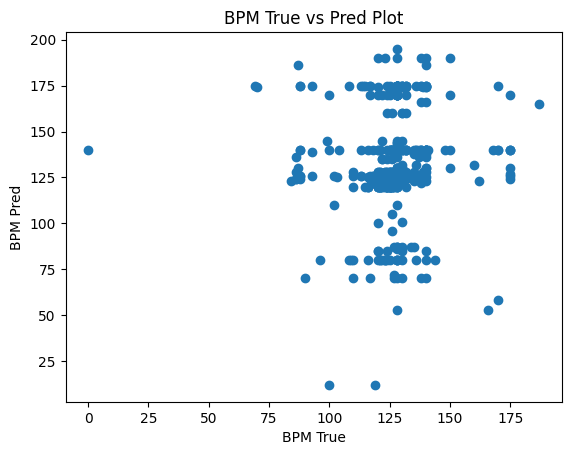

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Generating random data
x = df['bpm']
y = df['pred_bpm']

# Creating the scatter plot
plt.scatter(x, y)

# Adding title and labels
plt.title('BPM True vs Pred Plot')
plt.xlabel('BPM True')
plt.ylabel('BPM Pred')

# Showing the plot
plt.show()


In [55]:
diff_bpm.describe()

count    526.000000
mean      18.923954
std       22.592917
min        0.000000
25%        2.000000
50%        8.000000
75%       36.000000
max      140.000000
dtype: float64

### Evaluating their music understanding

In [ ]:
q1 = 'What is the genre of this music?'
prompts1 = encode_prompt(q1)

In [ ]:
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

2024-05-03 01:08:40.680546: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 01:08:55.656329: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 01:09:09.442745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Piano Instrumental


In [ ]:
q1 = 'What is the key used in the music?'
q1 = 'What is the key of the piece?'
prompts1 = encode_prompt(q1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/_43OOP6UEw0.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

D minor
F minor


In [ ]:
q1 = 'Example of scene that suit this music'
prompts1 = encode_prompt(q1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/_43OOP6UEw0.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

The music is playing in the background of a scene that is taking place in a city.
This music can be played in a scene of a movie where the characters are having a relaxing time.


In [ ]:
q1 = 'What is the bpm ? '
prompts1 = encode_prompt(q1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/_43OOP6UEw0.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

A minor
6/8


In [ ]:
q1 = 'What are the instruments used? '
prompts1 = encode_prompt(q1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/_43OOP6UEw0.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

The instruments used are drums, bass, and a male vocalist.
The instruments used are a piano, a string section, and a horn section.


In [ ]:
q1 = 'What is the pitch or fundamental frequency of audio sample?'
prompts1 = encode_prompt(q1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/_43OOP6UEw0.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

The pitch or fundamental frequency of audio sample is not mentioned in the caption.
The pitch or fundamental frequency of the audio sample is not specified.


In [ ]:
q1 = 'What is the emotion?'
prompts1 = encode_prompt(q1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/_43OOP6UEw0.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

The emotion is groovy and funky.
The emotion is soft and mellow.


In [ ]:
q1 = 'What is the vocal technique (like vibrato, yodeling) used?'
prompts1 = encode_prompt(q1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/_43OOP6UEw0.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)
audio_path = f'/l/users/xinyue.li/caption/dataset/audios/__uEjp7_UDw.mp3'
output1 = multimodal_generate(audio_path, 1, prompts1, 100, 20.0, 0.0, 512, 0.6, 0.8)
print(output1)

The vocal technique used is not specified in the caption.
The vocal technique used is vibrato.
